[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239412-lesson-5-router)

# Router(라우터0

## 복습

우리는 `메시지`를 상태로 사용하고 바인딩된 도구를 가진 채팅 모델을 활용하는 그래프를 구축했습니다.

이 그래프는 다음을 수행할 수 있음을 확인했습니다:

* 도구 호출 반환
* 자연어 응답 반환

## 목표

이를 라우터로 생각할 수 있습니다. 채팅 모델은 사용자 입력에 따라 직접 응답 또는 도구 호출 사이를 라우팅합니다.

이는 LLM이 도구 호출 또는 직접 응답을 통해 제어 흐름을 지시하는 에이전트의 간단한 예시입니다. 

![](https://i.imgur.com/XHww4wO.png)

두 가지 출력 모두 처리할 수 있도록 그래프를 확장해 보겠습니다!

이를 위해 두 가지 아이디어를 활용할 수 있습니다:

(1) 도구를 호출할 노드를 추가합니다.

(2) 채팅 모델 출력을 확인하고, 도구 호출 노드로 연결하거나 도구 호출이 수행되지 않으면 단순히 종료하는 조건부 에지를 추가합니다.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph 

In [2]:
from dotenv import load_dotenv

load_dotenv("../.env", override=True, verbose=True)

True

In [ ]:
from langchain_openai import ChatOpenAI


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

[`ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode)를 사용하고, 단순히 도구 목록을 전달하여 이를 초기화합니다. 
 
 조건부 에지로는 [`tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition)을 사용합니다.

In [ ]:
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition


def agent(state: MessagesState):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}


builder = StateGraph(MessagesState)
builder.add_node("agent", agent)
builder.add_node("tools", ToolNode([multiply]))
builder.add_conditional_edges("agent", tools_condition)
builder.set_entry_point("agent")
builder.set_finish_point("tools")
graph = builder.compile()

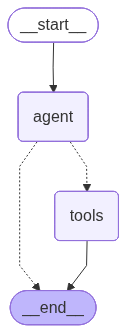

In [9]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

이제 그래프가 도구를 실행하는 것을 확인할 수 있습니다!

`ToolMessage`로 응답합니다.

In [10]:
from langchain_core.messages import HumanMessage

response = graph.invoke({"messages": [HumanMessage("1 곱하기 2는 얼마인가요?")]})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

1 곱하기 2는 얼마인가요?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_NHReX9FyLVW0atVJOe0zMuu0)
 Call ID: call_NHReX9FyLVW0atVJOe0zMuu0
  Args:
    a: 1
    b: 2
================================= Tool Message =================================
Name: multiply

2



## LangGraph Studio

랭그래프 스튜디오에 대한 설명은 [여기](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server)와 [여기](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)를 참조하세요. 로컬 개발 서버를 시작하려면, 이 모듈의 `/studio` 디렉터리에서 터미널에 다음 명령어를 실행하세요:

```
langgraph dev
```

다음과 같은 출력이 표시되어야 합니다:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API 문서: http://127.0.0.1:2024/docs
```

브라우저를 열고 스튜디오 UI로 이동하세요: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.
스튜디오에서 `router`를 로드하세요. 이 라우터는 `module-1/studio/langgraph.json`에 설정된 `module-1/studio/router.py`를 사용합니다.